In [1]:
import torch
from torch import nn
from PIL import Image
import os

In [2]:
data = 'camvid_data/'
train_labels = [data+'train_labels/'+x for x in os.listdir(data+'train_labels/')]
test_labels = [data+'val_labels/'+x for x in os.listdir(data+'val_labels/')]
masks = train_labels+test_labels
len(train_labels), len(test_labels), len(masks)

(601, 100, 701)

In [3]:
from torch.utils.data import Dataset, DataLoader

image_size = (256, 256)
class CustomData(Dataset):

    def __init__(self, masks, transform):
        self.masks = masks
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.masks)
    
    def __getitem__(self, index):
        mask = self.masks[index]
        mask = Image.open(mask).convert("RGB")
        mask = self.transform(mask)
        return mask

In [4]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(p=0.8),
    transforms.ToTensor()
])
dataset = CustomData(masks, transform=transform)
dataloader = DataLoader(dataset=dataset, batch_size=32, shuffle=True)

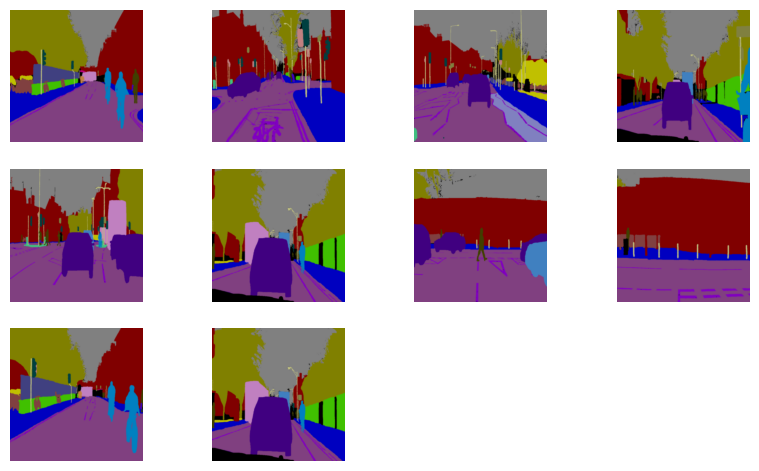

In [5]:
import random
import matplotlib.pyplot as plt

def plot_from_dataset(images, samples=10):
    plt.figure(figsize=(10, 10))
    for i in range(1, samples+1):
        idx = random.randint(0, len(images)-1)
        plt.subplot(samples//2, 4, i)
        plt.imshow(images[idx].permute(1, 2, 0))
        plt.axis("off")
    plt.show()
plot_from_dataset(dataset)

In [6]:
dataset[0].shape

torch.Size([3, 256, 256])

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [94]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, in_channels=100, out_channels=3, features=64):
        super(Generator, self).__init__()

        # Encoder (inspired by ResNet blocks for improved gradient flow)
        def encoder_block(in_features, out_features, stride=1):
            return nn.Sequential(
                nn.Conv2d(in_features, out_features, kernel_size=4, stride=stride, padding=1, bias=False),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_features, out_features, kernel_size=4, stride=1, padding=1, bias=False),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            )

        self.enc1 = encoder_block(in_channels, features, stride=1)
        self.enc2 = encoder_block(features, features * 2, stride=2)
        self.enc3 = encoder_block(features * 2, features * 4, stride=2)
        self.enc4 = encoder_block(features * 4, features * 8, stride=2)

        # Bottleneck (optional, can be used for deeper architectures)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, kernel_size=4, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(features * 8),
            nn.ReLU(inplace=True)
        )

        # Decoder (mirrored encoder with transposed convolutions)
        def decoder_block(in_features, out_features, stride=1):
            return nn.Sequential(
                nn.ConvTranspose2d(in_features, out_features, kernel_size=4, stride=stride, padding=1, bias=False),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(out_features, out_features, kernel_size=4, stride=1, padding=1, bias=False),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            )

        self.dec4 = decoder_block(features * 8, features * 4, stride=2)
        self.dec3 = decoder_block(features * 4 * 2, features * 2, stride=2)  # Modified to account for skip connections
        self.dec2 = decoder_block(features * 2 * 2, features, stride=2)  # Modified to account for skip connections
        self.dec1 = decoder_block(features * 2, out_channels, stride=1)
        self.tanh = nn.Tanh()  # Use tanh for image outputs in [-1, 1] range

    def forward(self, x):
        x = self.enc1(x)
        print(x.shape)
        x_enc1 = x

        x = self.enc2(x)
        print(x.shape)
        x_enc2 = x

        x = self.enc3(x)
        print(x.shape)
        x_enc3 = x

        x = self.enc4(x)
        print(x.shape)

        x = self.bottleneck(x)
        print(x.shape)

        x = self.dec4(x)
        print(x.shape)
        x = torch.cat([x, x_enc3], dim=1)

        x = self.dec3(x)
        x = torch.cat([x, x_enc2], dim=1)

        x = self.dec2(x)
        x = torch.cat([x, x_enc1], dim=1)

        x = self.dec1(x)
        return self.tanh(x)


In [95]:
generator = Generator().to(device)

In [96]:
preds = generator(torch.randn(size=(1, 100, 64, 64)).to(device))

torch.Size([1, 64, 62, 62])
torch.Size([1, 128, 30, 30])
torch.Size([1, 256, 14, 14])
torch.Size([1, 512, 6, 6])
torch.Size([1, 512, 5, 5])
torch.Size([1, 256, 11, 11])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 11 but got size 14 for tensor number 1 in the list.

In [76]:
preds.shape

torch.Size([1, 64, 64, 64])